# Projection and interpolation
## Approximation of a function into a finite element space

Suppose that we have a continous function 
$$f: x\in \Omega\to f(x)\in \mathbb{R}$$
and we want to approximate it in the finite element space $$\mathcal{V}_n=\mathrm{span}\{\varphi_1,\ldots,\varphi_n\}$$
where the
$\varphi_i$'s are the finite element basis function. We denote the finite element approximation of $f$ by 
$$
f_n(x):=\sum_{i=1}^n F_i\varphi_i(x)
$$
where $F_i$'s are the finite element coefficients.

We discuss two methods to determine the $F_i$'s and hence $f_n$ given the function $f$ and the finite element space $\mathcal{V}_n$:
1. **Interpolation**
2. **Projection**

To make explicit example with FEniCS, let us define a mesh,  several finite element spaces on this mesh, and an analYtical expression for a possible function $f$, that we will use in the example below. We take a quite large mesh to have an idea of the timings.

In [1]:
import dolfin
import matplotlib.pyplot as plt
mesh = dolfin.UnitSquareMesh(1000,100) 
P1 = dolfin.FunctionSpace(mesh,'P',1)
DG = dolfin.FunctionSpace(mesh,'DG',0)
P1_vect = dolfin.VectorFunctionSpace(mesh,'P',1)
DG_vect = dolfin.VectorFunctionSpace(mesh,'DG',0)
f = dolfin.Expression("sin(x[0])*sin(x[1])",degree=1)
print("The number of dof of the P1 space is {:d}".format(P1.dim()))
print("The number of dof of the DG space is {:d}".format(DG.dim()))
print("The number of dof of the P1_vect space is {:d}".format(P1_vect.dim()))
print("The number of dof of the DG_vect space is {:d}".format(DG_vect.dim()))

The number of dof of the P1 space is 101101
The number of dof of the DG space is 200000
The number of dof of the P1_vect space is 202202
The number of dof of the DG_vect space is 400000


## Interpolation

We consider the case of Lagrange finite elements, where the degrees of freedom are the pointwise evaluation of functions in a set points, the *nodes*. Note that in linear elements the nodes concide with the vertices of the mesh, but in quadratic elements there are additional nodes. 

The interpolation imposes that for each *node* $j$ the pointwise evaluation of $f_n$ coincides with the pointwise evaluation of $f$. This give the system: 

$$
f(x_j)=f_n(x_j), \quad\forall i=1\ldots n
$$

A key property of the finite element basis function for Lagrrange elements is that $\varphi_i(x_j)=1$ if $j=i$ and $0$ if $j\neq i$. 
Hence 

$$
f_n(x_j) :=\sum_{i=1}^n F_i\varphi_i(x_j)=F_j
$$

We can conclude that the interpolation of $f$ in $V_n$ is simply obtained taking $F_i=f(x_i)$:
$$
f_n^{(\mathrm{int})}(x_j) = \sum_{i=1}^n f(x_i)\varphi_i(x_j)
$$

This is done with the command `fint_n = interpolate(f,V_n)` in FEniCS, see the example below. This is quite efficient in terms of timing.

In [2]:
%%time
f_interpolate_P1 = dolfin.interpolate(f,P1)

CPU times: user 38.9 ms, sys: 586 µs, total: 39.5 ms
Wall time: 39.4 ms


Note that the following two direct interpolation of UFL expressions does not work:

In [3]:
# this does not work ufl_expression = grad(f)
try:
    dolfin.interpolate(2*f+3,P1)
    # Raised only if the above statement does not raise an exception
    raise RuntimeError()
except AttributeError as e:
    print(f"An exception was caught: {e}")

An exception was caught: 'Sum' object has no attribute '_cpp_object'


In [4]:
try:
    dolfin.interpolate(dolfin.grad(f_interpolate_P1),DG_vect)
    # Raised only if the above statement does not raise an exception
    raise RuntimeError()
except Exception as e:
    print(f"An exception was caught: {e}")

An exception was caught: 'Grad' object has no attribute '_cpp_object'


## Projection

The basic idea of the projection to obtain a finite element approximation $f_n$ of $f$ is to write the equality $f = f_n$ in weak form. We define the projection of $f$ in $\mathcal{V}_n$ as the function $f_n\in\mathcal{V}_h$ such that

$$
\int_\Omega f_n(x)\cdot \hat f(x),\mathrm{d}x
=
\int_\Omega f(x)\cdot \hat f(x),\mathrm{d}x,\quad \forall \hat f \in \mathcal{V}_n
$$

In the weak form above  $f_n$ is the unknown 'trial function', $\hat f$ is an arbritary test function in the finite element space, and $f$ is the given function to approximate. We can rewrite the equality above in the stardard form
$$
a(f_n,\hat f)=\ell(\hat f), \quad \forall \hat f \in \mathcal{V}_n
$$
where the bilinear and linear form are given by
$$
a(f_n,\hat{f})= \int_\Omega f_n(x)\cdot \hat f(x),\mathrm{d}x, 
\quad 
\ell(\hat f)=\int_\Omega f(x)\cdot \hat f(x),\mathrm{d}x,
$$
In the finite element space, writing $f_n$ and $\hat{f}$ as linear combinations of the basis functions $\varphi_i$'s, this weak fomulation gives the usual linear system
$$
\underline{\underline{A}} \,\underline{F}= \underline{b},\quad A_{ij}=a(\varphi_i,\varphi_j),\quad b_j=\ell(\varphi_j)
$$
Hence the projection of $f$ in $\mathcal{V}_n$ is given by 
$$
f_n^{\mathrm{(proj)}}(x_j) :=\sum_{i=1}^n F_i\varphi_i(x_j),
$$
where
$F_i$ is the solution to $A_{ij} F_j= b_i$.

We can do this operation by writing the weak formulation and solving the corresponding linear system. This takes more time, because solving a linear system is expensive.

In [5]:
%%time
f_proj_P1 = dolfin.Function(P1)
f_test_P1 = dolfin.TestFunction(P1)
f_trial_P1 = dolfin.TrialFunction(P1)
a = f_trial_P1*f_test_P1*dolfin.dx
L = f*f_test_P1*dolfin.dx
A, b = dolfin.assemble_system(a,L)
dolfin.solve(A,f_proj_P1.vector(),b)

CPU times: user 2.27 s, sys: 85.9 ms, total: 2.36 s
Wall time: 552 ms


1

The function `project(f,V_n)` of dolfin does exactly this operation in one line:

In [6]:
%%time
dolfin.project(f,P1)

CPU times: user 2.28 s, sys: 74.8 ms, total: 2.35 s
Wall time: 554 ms


Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1)), 42)

Projection is more expensive than interpolation, but more general. All of this work:

In [ ]:
%%time
dolfin.project(2*f+3,P1)
gradf_proj_dg = dolfin.project(dolfin.grad(f_interpolate_P1),DG_vect)
gradf_proj_p1 = dolfin.project(dolfin.grad(f_interpolate_P1),P1_vect)
dolfin.plot(gradf_proj_dg)

We can also project from one function space (and mesh) to another. For example, let us project on a coarse mesh.

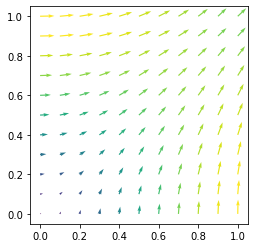

In [8]:
mesh_coarse = dolfin.UnitSquareMesh(10,10) 
gradf_proj_p1_coarse = dolfin.project(gradf_proj_p1,dolfin.VectorFunctionSpace(mesh_coarse,'DG',0))
dolfin.plot(gradf_proj_p1_coarse)
plt.show()

# Interpolation/projection error

In [9]:
f_proj = dolfin.project(f, P1)
f_interp = dolfin.interpolate(f, P1)

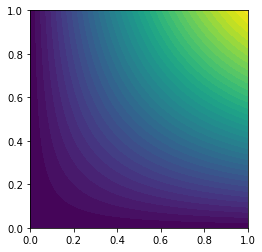

In [10]:
dolfin.plot(f_proj)

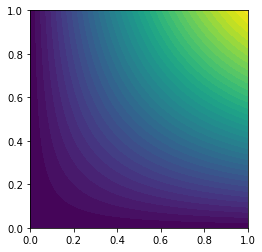

In [11]:
dolfin.plot(f_interp)

In [12]:
dolfin.errornorm(f, f_interp, "L2")

2.1857737117356696e-06

In [13]:
dolfin.errornorm(f, f_proj, "L2")

2.185773711662274e-06

In [14]:
dolfin.errornorm(f_proj, f_interp, "L2")

1.2940048066594053e-16

Explain the above results?

## Application to mechanics

In elasticity, projection is required to calculate strain and stress.
As an example, we define a given displacement field (vector valued). We cannot do it by interpolation (at least in FEniCS).

In [15]:
mesh = dolfin.UnitSquareMesh(10,10)
P1_vect = dolfin.VectorFunctionSpace(mesh,"P",1)
u = dolfin.interpolate(dolfin.Expression(("0.1*sin(2*pi*x[0])","cos(4*x[1])"),degree=2), P1_vect)

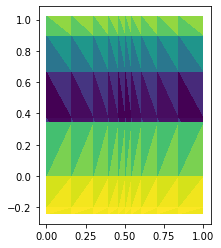

In [16]:
dolfin.plot(u, mode="displacement")

In [17]:
P1_tens = dolfin.TensorFunctionSpace(mesh,"DG",0)
strain = dolfin.project(dolfin.sym(dolfin.grad(u)),P1_tens)

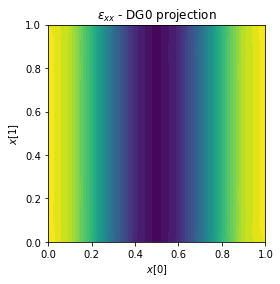

In [18]:
dolfin.plot(strain[0,0])
plt.title(r"$\varepsilon_{xx}$ - DG0 projection")
plt.xlabel(r"$x[0]$")
plt.ylabel(r"$x[1]$")
plt.show()